##### Oil Price Prediction

- Prepare time-series data for ML
- ML models
- https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html#sphx-glr-auto-examples-model-selection-plot-cv-indices-py

In [10]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import helper as helper
import sklearn 
from tqdm import tqdm
%matplotlib inline

In [11]:
df_BRT = pd.read_excel('../data/RBRTEd.xls', sheet_name=1, skiprows=2)
df_BRT = df_BRT.rename(columns={'Europe Brent Spot Price FOB (Dollars per Barrel)': 'BRT'})

# set Date as index
# df_BRT.dtypes
# df_BRT['Date'] = pd.to_datetime(df_BRT['Date'],format='%Y-%m-%d')
df_BRT.index = df_BRT['Date']
df_BRT = df_BRT.drop(['Date'], axis=1)

df_BRT.head(3).append(df_BRT.tail(3))

BRT
Date             
1987-05-20  18.63
1987-05-21  18.45
1987-05-22  18.55
2018-11-15  65.61
2018-11-16  65.29
2018-11-19  64.14

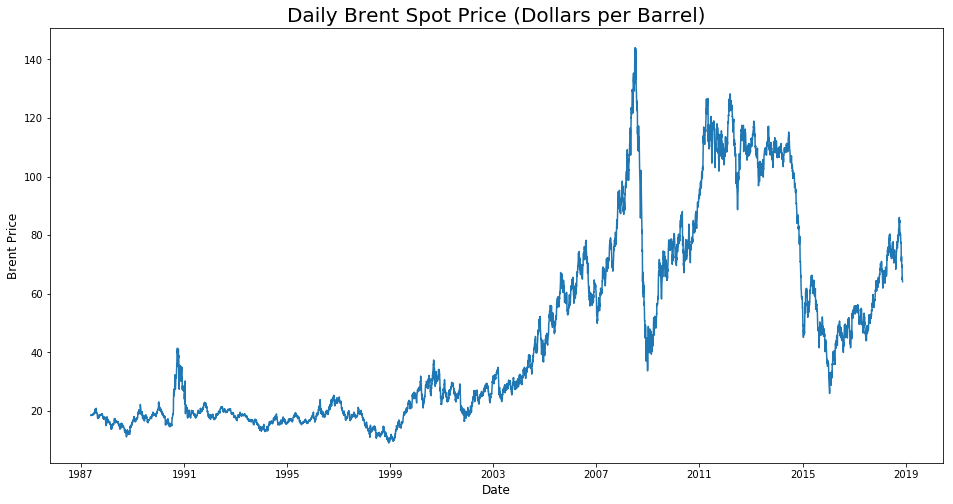

In [12]:
plt.figure(figsize=(16,8))
plt.plot(df_BRT['BRT'])
plt.title('Daily Brent Spot Price (Dollars per Barrel)', fontsize=20)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Brent Price', fontsize=12)

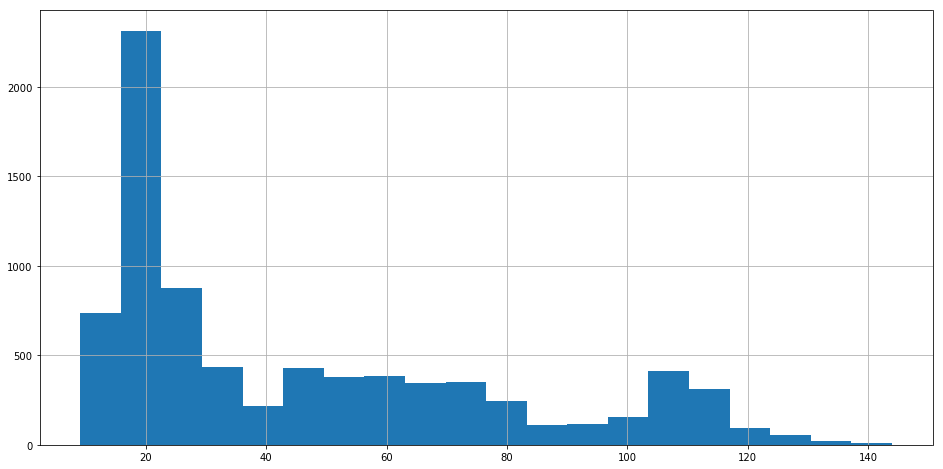

In [13]:
plt.figure(figsize=(16,8))
plt.hist(df_BRT['BRT'], bins=20)
plt.grid()

In [14]:
# log transform
df_BRT['BRT'] = np.log(df_BRT['BRT'])

## Prepare time-series data for ML

In [16]:
n_in_max=120
n_in_min=90
n_out=1
df_ML = helper.ts_to_ml(df_BRT, col_shift='BRT', n_in_max=n_in_max, n_in_min=n_in_min, n_out=n_out, dropnan=True)
# only focus on oil price from 2000
df_ML = df_ML[df_ML.index >= '2000-01-01']
df_ML.head(3)

t     t-120     t-119     t-118     t-117     t-116  \
Date                                                                     
2000-01-04  3.175968  2.941276  2.969902  2.969388  2.939162  2.966303   
2000-01-05  3.166319  2.969902  2.969388  2.939162  2.966303  2.983153   
2000-01-06  3.159126  2.969388  2.939162  2.966303  2.983153  2.961658   

               t-115     t-114     t-113     t-112    ...        t-100  \
Date                                                  ...                
2000-01-04  2.983153  2.961658  2.924236  2.944965    ...     2.962175   
2000-01-05  2.961658  2.924236  2.944965  2.980111    ...     3.004692   
2000-01-06  2.924236  2.944965  2.980111  2.982140    ...     3.024320   

                t-99      t-98      t-97      t-96      t-95      t-94  \
Date                                                                     
2000-01-04  3.004692  3.024320  3.011606  3.025776  3.029167  3.025776   
2000-01-05  3.024320  3.011606  3.025776  3.029167  3.025776  3.029650   
2000-01-06  3.011606  3.025776  3.029167  3.025776  3.029650  3.040706   

                t-93      t-92      t-91  
Date                                      
2000-01-04  3.029650  3.040706  3.049747  
2000-01-05  3.040706  3.049747  3.042616  
2000-01-06  3.049747  3.042616  3.019449  

[3 rows x 31 columns]

### ML models 
- https://machinelearningmastery.com/how-to-develop-deep-learning-models-for-univariate-time-series-forecasting/

In [17]:
# df_train, df_test = helper.train_test_split(df_ML, pct_test=0.2)
cutoff_date = '2016-01-01'
df_train = df_ML[df_ML.index < cutoff_date]
df_test = df_ML[df_ML.index >= cutoff_date]
df_train, df_valid = helper.train_test_split(df_train, pct_test=0.2)
# df_train, df_test = helper.train_test_split(df_ML, pct_test=0.2)
print('Observations: %d' % (len(df_ML)))
print('Training Observations: %d' % (len(df_train)))
print('Validation Observations: %d' % (len(df_valid)))
print('Testing Observations: %d' % (len(df_test)))

col_resp = 't'
col_feature = [item for item in list(df_train) if item != col_resp]
col_feature = ['t-120', 't-110', 't-100', 't-91']
X_train = df_train[col_feature]
Y_train = df_train[col_resp]#.values.ravel()
X_valid = df_valid[col_feature]
Y_valid = df_valid[col_resp]

Observations: 4798
Training Observations: 3249
Validation Observations: 812
Testing Observations: 737


In [19]:
from xgboost import XGBRegressor
from sklearn import neighbors
from sklearn import ensemble
# from sklearn.isotonic import IsotonicRegression

# model = ensemble.RandomForestRegressor(n_estimators = 10, min_samples_split=10, min_samples_leaf=80)
# model = XGBRegressor(learning_rate =0.01, max_depth=10, n_estimators=15)
model = XGBRegressor()
# model = neighbors.KNeighborsRegressor(n_neighbors=5, weights='distance')
model.fit(X=X_train, y=Y_train)

/Users/yangcong/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

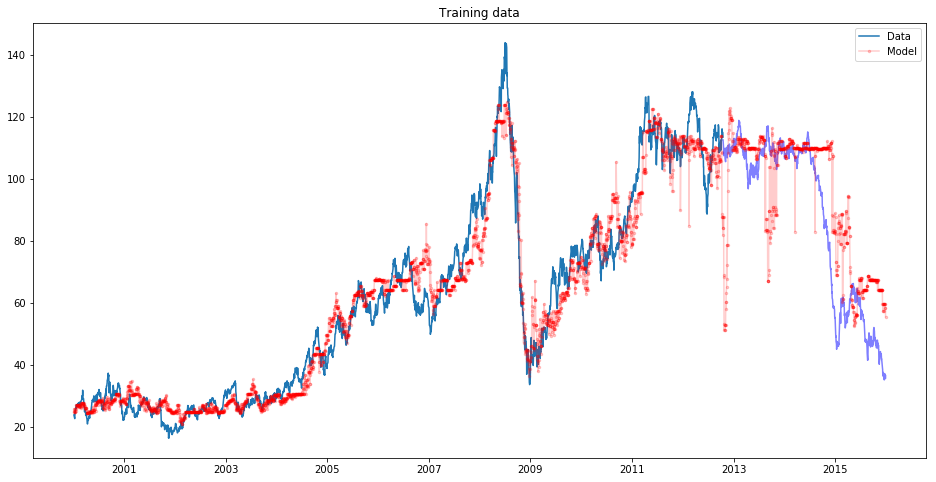

In [20]:
plt.figure(figsize=(16,8))
plt.plot(X_train.index, np.exp(Y_train))
plt.plot(X_train.index, np.exp(model.predict(X_train)), \
         'r.-', markersize=5, alpha=.2)
plt.plot(X_valid.index, np.exp(Y_valid), \
         'b-', markersize=10, alpha = .5 )
plt.plot(X_valid.index, np.exp(model.predict(X_valid)), \
         'r.-', markersize=5, alpha=.2)
plt.legend(('Data', 'Model'), loc='upper right')
plt.title('Training data')

In [21]:
# plt.figure(figsize=(16,8))
# plt.plot(X_train.index, Y_train*scaled_features['BRT'][1]+scaled_features['BRT'][0])
# plt.plot(X_train.index, model.predict(X_train)*scaled_features['BRT'][1]+scaled_features['BRT'][0], \
#          'r.-', markersize=5, alpha=.2)
# plt.plot(X_valid.index, Y_valid*scaled_features['BRT'][1]+scaled_features['BRT'][0], \
#          'b-', markersize=10, alpha = .5 )
# plt.plot(X_valid.index, model.predict(X_valid)*scaled_features['BRT'][1]+scaled_features['BRT'][0], \
#          'r.-', markersize=5, alpha=.2)
# plt.legend(('Data', 'Model'), loc='upper right')
# plt.title('Training data')

### For model performance testing, predicted response will be model inputs for later time stamps. 

In [22]:
Y_test = df_BRT[df_BRT.index > df_train.index[-1]].copy()
Y_test['predict'] = np.nan
# testing dataset #
ts_test = df_BRT.copy()
ts_test = ts_test.reset_index()
# set testing data to nan
index_test = ts_test.index[ts_test['Date'] > df_valid.index[-1]][0]
ts_test.loc[ts_test.index >= index_test, 'BRT'] = np.nan
# filter to records needed
ts_test = ts_test[ts_test.index >= (index_test - n_in_max - 1) ]

In [23]:
for i in tqdm(range(index_test, df_BRT.shape[0], 1)):
    X_test = helper.ts_to_ml(ts_test[ts_test.index <= i], 
                         col_shift='BRT', 
                         n_in_max=n_in_max, 
                         n_in_min=n_in_min, 
                         n_out=1, 
                         dropnan=False)
    X_test = X_test[X_test.index == i]
    y_hat = model.predict(X_test[col_feature])[0]
    ts_test.loc[i, 'BRT'] = y_hat
    Y_test.loc[Y_test.index==ts_test.loc[i,'Date'], 'predict'] = y_hat

100%|██████████| 737/737 [00:23<00:00, 31.49it/s]


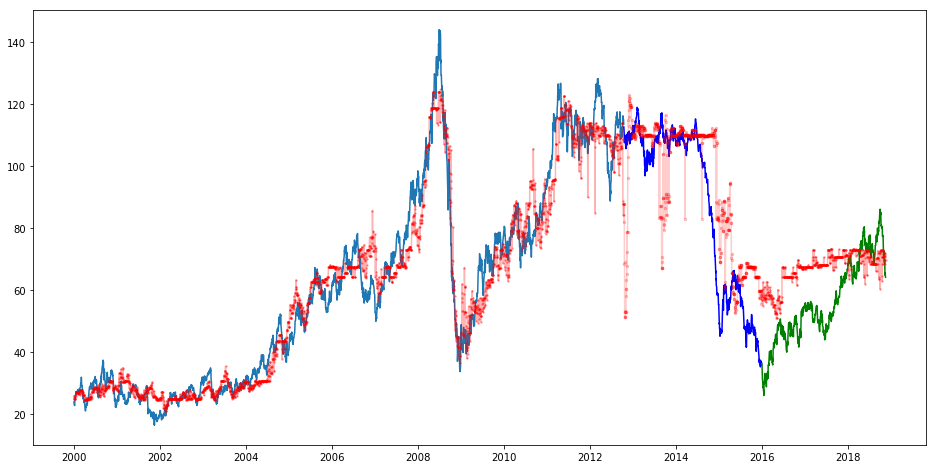

In [24]:
plt.figure(figsize=(16,8))
plt.plot(np.exp(df_train['t']))
plt.plot(np.exp(df_valid['t']), 'b')
plt.plot(np.exp(df_test['t']), 'g')
plt.plot(X_train.index, np.exp(model.predict(X_train)),\
         'r.-', markersize=3, alpha=.3)
plt.plot(X_valid.index, np.exp(model.predict(X_valid)), \
         'r.-', markersize=5, alpha=.2)
plt.plot(np.exp(Y_test['predict']), \
         'r.-', markersize=3, alpha=.3)
# plt.legend(('Training data', 'Testing data', 'Training_XGB', 'Testing_XGB'), loc='upper right')

In [ ]:
# plt.figure(figsize=(16,8))
# plt.plot(df_train['t']*scaled_features['BRT'][1]+scaled_features['BRT'][0])
# plt.plot(df_valid['t']*scaled_features['BRT'][1]+scaled_features['BRT'][0], 'b')
# plt.plot(df_test['t']*scaled_features['BRT'][1]+scaled_features['BRT'][0], 'g')
# plt.plot(X_train.index, y_train_model*scaled_features['BRT'][1]+scaled_features['BRT'][0],\
#          'r.-', markersize=3, alpha=.3)
# plt.plot(X_valid.index, model.predict(X_valid)*scaled_features['BRT'][1]+scaled_features['BRT'][0], \
#          'r.-', markersize=5, alpha=.2)
# plt.plot(Y_test['predict']*scaled_features['BRT'][1]+scaled_features['BRT'][0], \
#          'r.-', markersize=3, alpha=.3)
# # plt.legend(('Training data', 'Testing data', 'Training_XGB', 'Testing_XGB'), loc='upper right')

### LSTM
- https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/
- https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
- https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/
- https://www.kaggle.com/ternaryrealm/lstm-time-series-explorations-with-keras
- https://machinelearningmastery.com/diagnose-overfitting-underfitting-lstm-models/

In [25]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
# from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.optimizers import Adam

Using TensorFlow backend.


In [26]:
# log transform
df_BRT['BRT'] = np.log(df_BRT['BRT'])

# scale for Neural Netowrk
scaled_features = {}
for each in list(df_BRT):
    mean, std = df_BRT[each].mean(), df_BRT[each].std()
    scaled_features[each] = [mean, std]
    df_BRT.loc[:, each] = (df_BRT[each] - mean)/std

In [27]:
# df_train, df_test = helper.train_test_split(df_ML, pct_test=0.2)
cutoff_date = '2016-01-01'
df_train = df_ML[df_ML.index < cutoff_date]
df_test = df_ML[df_ML.index >= cutoff_date]
df_train, df_valid = helper.train_test_split(df_train, pct_test=0.2)
# df_train, df_test = helper.train_test_split(df_ML, pct_test=0.2)
print('Observations: %d' % (len(df_ML)))
print('Training Observations: %d' % (len(df_train)))
print('Validation Observations: %d' % (len(df_valid)))
print('Testing Observations: %d' % (len(df_test)))

col_resp = 't'
col_feature = [item for item in list(df_train) if item != col_resp]
col_feature = ['t-120', 't-110', 't-100', 't-91']
X_train = df_train[col_feature]
Y_train = df_train[col_resp]#.values.ravel()
X_valid = df_valid[col_feature]
Y_valid = df_valid[col_resp]

Observations: 4798
Training Observations: 3249
Validation Observations: 812
Testing Observations: 737


In [28]:
n_in_max=120
n_in_min=90
n_out=1
df_ML = helper.ts_to_ml(df_BRT, col_shift='BRT', n_in_max=n_in_max, n_in_min=n_in_min, n_out=n_out, dropnan=True)
# only focus on oil price from 2000
df_ML = df_ML[df_ML.index >= '2000-01-01']
df_ML.head(3)

t     t-120     t-119     t-118     t-117     t-116  \
Date                                                                     
2000-01-04 -0.491634 -0.877707 -0.829000 -0.829869 -0.881323 -0.835096   
2000-01-05 -0.506937 -0.829000 -0.829869 -0.881323 -0.835096 -0.806610   
2000-01-06 -0.518374 -0.829869 -0.881323 -0.835096 -0.806610 -0.842978   

               t-115     t-114     t-113     t-112    ...        t-100  \
Date                                                  ...                
2000-01-04 -0.806610 -0.842978 -0.906927 -0.871403    ...    -0.842099   
2000-01-05 -0.842978 -0.906927 -0.871403 -0.811742    ...    -0.770430   
2000-01-06 -0.906927 -0.871403 -0.811742 -0.808318    ...    -0.737686   

                t-99      t-98      t-97      t-96      t-95      t-94  \
Date                                                                     
2000-01-04 -0.770430 -0.737686 -0.758872 -0.735264 -0.729632 -0.735264   
2000-01-05 -0.737686 -0.758872 -0.735264 -0.729632 -0.735264 -0.728829   
2000-01-06 -0.758872 -0.735264 -0.729632 -0.735264 -0.728829 -0.710512   

                t-93      t-92      t-91  
Date                                      
2000-01-04 -0.728829 -0.710512 -0.695581  
2000-01-05 -0.710512 -0.695581 -0.707354  
2000-01-06 -0.695581 -0.707354 -0.745792  

[3 rows x 31 columns]

In [29]:
# X_train = np.reshape(np.array(X_train), (X_train.shape[0], 1, X_train.shape[1]))
# X_valid = np.reshape(np.array(X_valid), (X_valid.shape[0], 1, X_valid.shape[1]))

In [53]:
model = Sequential()
# model.add(LSTM(10, input_shape=(1, len(col_feature)), return_sequences=True, activation='sigmoid'))
# model.add(LSTM(10, activation='sigmoid'))
model.add(Dense(16, input_dim = X_train.shape[1], activation='sigmoid'))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1, activation='linear'))
model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.002))
# model.fit(X_train, Y_train, epochs=10, batch_size=5, verbose=1)
history = model.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), epochs=40, batch_size=64, verbose=1)

Train on 3249 samples, validate on 812 samples
Epoch 1/40
3249/3249 [==============================] - 2s 541us/step - loss: 6.0958 - val_loss: 1.7662
Epoch 2/40
3249/3249 [==============================] - 0s 44us/step - loss: 0.3956 - val_loss: 0.2712
Epoch 3/40
3249/3249 [==============================] - 0s 46us/step - loss: 0.2965 - val_loss: 0.3211
Epoch 4/40
3249/3249 [==============================] - 0s 43us/step - loss: 0.2905 - val_loss: 0.3061
Epoch 5/40
3249/3249 [==============================] - 0s 58us/step - loss: 0.2852 - val_loss: 0.3045
Epoch 6/40
3249/3249 [==============================] - 0s 37us/step - loss: 0.2798 - val_loss: 0.3129
Epoch 7/40
3249/3249 [==============================] - 0s 33us/step - loss: 0.2750 - val_loss: 0.2966
Epoch 8/40
3249/3249 [==============================] - 0s 33us/step - loss: 0.2708 - val_loss: 0.2669
Epoch 9/40
3249/3249 [==============================] - 0s 34us/step - loss: 0.2667 - val_loss: 0.2895
Epoch 10/40
3249/3249 [==

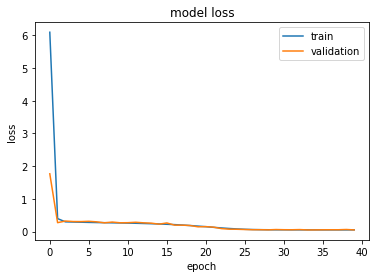

In [54]:
# print(history.history.keys())

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

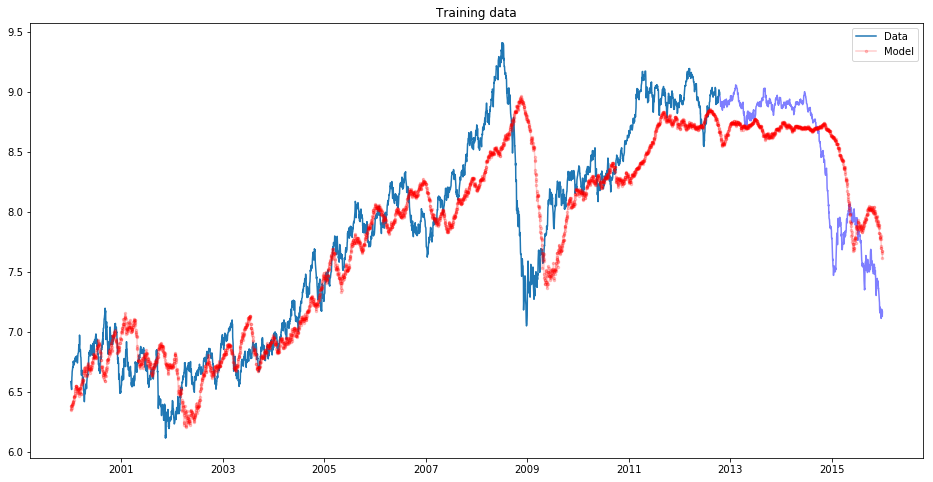

In [55]:
plt.figure(figsize=(16,8))
plt.plot(np.exp(Y_train*scaled_features['BRT'][1]+scaled_features['BRT'][0]))
plt.plot(df_train.index, np.exp(model.predict(X_train)*scaled_features['BRT'][1]+scaled_features['BRT'][0]), \
         'r.-', markersize=5, alpha=.2)
plt.plot(df_valid.index, np.exp(Y_valid*scaled_features['BRT'][1]+scaled_features['BRT'][0]), \
         'b-', markersize=10, alpha = .5 )
plt.plot(df_valid.index, np.exp(model.predict(X_valid)*scaled_features['BRT'][1]+scaled_features['BRT'][0]), \
         'r.-', markersize=5, alpha=.2)
plt.legend(('Data', 'Model'), loc='upper right')
plt.title('Training data')

In [56]:
for i in tqdm(range(index_test, df_BRT.shape[0], 1)):
    X_test = helper.ts_to_ml(ts_test[ts_test.index <= i], 
                         col_shift='BRT', 
                         n_in_max=n_in_max, 
                         n_in_min=n_in_min, 
                         n_out=1, 
                         dropnan=False)
    X_test = X_test[X_test.index == i]
    y_hat = model.predict(X_test[col_feature])[0]
    ts_test.loc[i, 'BRT'] = y_hat
    Y_test.loc[Y_test.index==ts_test.loc[i,'Date'], 'predict'] = y_hat

100%|██████████| 737/737 [00:20<00:00, 39.46it/s]


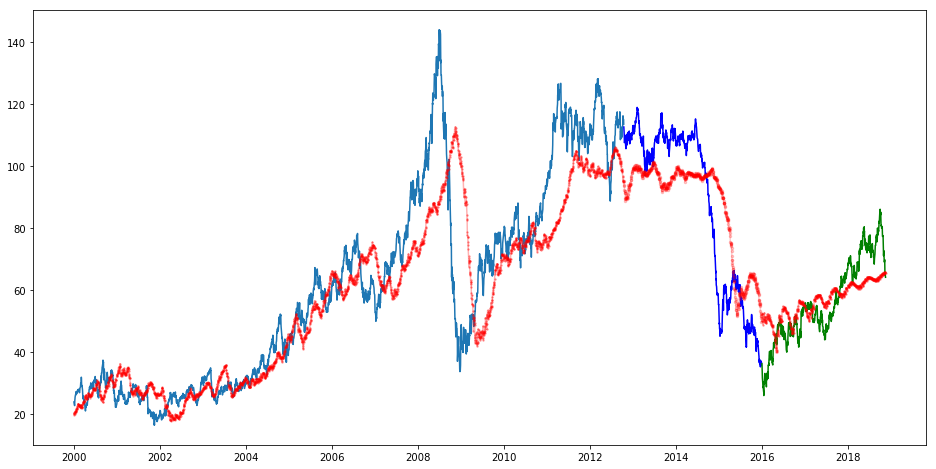

In [57]:
plt.figure(figsize=(16,8))
plt.plot(np.exp(df_train['t']))
plt.plot(np.exp(df_valid['t']), 'b')
plt.plot(np.exp(df_test['t']), 'g')
plt.plot(X_train.index, np.exp(model.predict(X_train)),\
         'r.-', markersize=3, alpha=.3)
plt.plot(X_valid.index, np.exp(model.predict(X_valid)), \
         'r.-', markersize=5, alpha=.2)
plt.plot(np.exp(Y_test['predict']), \
         'r.-', markersize=3, alpha=.3)
# plt.legend(('Training data', 'Testing data', 'Training_XGB', 'Testing_XGB'), loc='upper right')